In [1]:
import time
import numpy as np
from pathlib import Path

from qspectro2d.core.bath_system.bath_class import BathSystem
from qspectro2d.config import DATA_DIR
from qspectro2d.spectroscopy import (
    get_max_workers,
    print_simulation_summary,
)
from qspectro2d.spectroscopy.calculations import (
    parallel_compute_1d_E_with_inhomogenity,
    check_the_solver,
    complex_polarization,
    compute_1d_polarization,
    extract_ift_signal_component,

)

from qspectro2d.visualization import (
    plot_example_evo,
    plot_example_polarization,
)

from qspectro2d.data import (
    save_data_file,
    save_info_file,
    generate_unique_data_filename,
)
from qspectro2d.core.simulation_class import (
    AtomicSystem,
    LaserPulseSequence,
    SimulationConfig,
    SimulationModuleOQS,
)

N_ATOMS = 1
DEFAULT_ODE_SOLVER = "Paper_eqs"
DEFAULT_RWA_SL = True

DEFAULT_BATH_TYPE = "paper"
DEFAULT_BATH_TEMP = 1e-5
DEFAULT_BATH_CUTOFF = 1e2
DEFAULT_BATH_GAMMA_0 = 1 / 300.0
DEFAULT_BATH_GAMMA_PHI = 1 / 100.0
DEFAULT_N_FREQS = 1
DEFAULT_PHASES = 1  # Number of phase cycles for the simulation
DEFAULT_DELTA_CM = 0.0  # Inhomogeneous broadening [cm⁻¹]
DEFAULT_IFT_COMPONENT = (
    -1,
    1,
    1, # has no influence
)  #  (0, 0, 0) == normal average || (-1, 1, 0) == photon echo signal


def create_simulation_module_from_configs(
    atom_config: dict,
    laser_config: dict,
    bath_config: dict,
    simulation_config: dict,
) -> SimulationModuleOQS:
    """
    Create a simulation module from the provided configuration dictionaries.

    Parameters:
        atom_config (dict): Atomic system configuration.
        laser_config (dict): Laser pulse sequence configuration.
        bath_config (dict): Bath parameters configuration.
        simulation_config (dict): Simulation parameters configuration.

    Returns:
        SimulationModuleOQS: Configured simulation class instance.
    """
    system = AtomicSystem.from_dict(atom_config)
    laser = LaserPulseSequence.from_delays(**laser_config)
    bath = BathSystem.from_dict(bath_config)

    return SimulationModuleOQS(
        simulation_config=SimulationConfig(**simulation_config),
        system=system,
        laser=laser,
        bath=bath,
    )


def run_single_t_coh_with_sim(
    sim_oqs: SimulationModuleOQS,
    t_coh: float,
    save_info: bool = False,
    time_cut: float = -np.inf,
) -> Path:
    """
    Run a single 1D simulation for a specific coherence time using existing SimulationModuleOQS.

    Parameters:
        sim_oqs (SimulationModuleOQS): Pre-configured simulation instance
        t_coh (float): Coherence time between 2 pump pulses [fs]
        save_info (bool): Whether to save simulation info
        time_cut (float): Time cutoff for solver validation

    Returns:
        Path: Relative path to the saved data directory
    """
    print(f"\n=== Starting t_coh = {t_coh:.2f} fs ===")

    # Update t_coh in the simulation config
    sim_oqs.simulation_config.t_coh = t_coh
    t_wait = sim_oqs.simulation_config.t_wait
    """
    #print(
    #    "the times are ", sim_oqs.times_global, sim_oqs.times_local, sim_oqs.times_det
    #)
    """
    sim_oqs.laser.update_delays = [0.0, t_coh, t_coh + t_wait]

    start_time = time.time()

    # Run the simulation
    print("Computing 1D polarization with parallel processing...")
    try:
        data = parallel_compute_1d_E_with_inhomogenity(
            sim_oqs=sim_oqs,
            time_cut=time_cut,
        )
        print("✅ Parallel computation completed successfully!")
    except Exception as e:
        print(f"❌ ERROR: Simulation failed: {e}")
        raise

    # Save data
    simulation_config_dict = sim_oqs.simulation_config.to_dict()
    abs_path = Path(
        generate_unique_data_filename(sim_oqs.system, simulation_config_dict)
    )
    data_path = Path(f"{abs_path}_data.npz")
    print(f"\nSaving data to: {data_path}")

    save_data_file(data_path, data, sim_oqs.times_det)

    rel_path = abs_path.relative_to(DATA_DIR)

    if save_info:
        # all_infos_as_dict = sim_oqs.to_dict() TODO update the saving to incorporate all the info data in one dict?
        info_path = Path(f"{abs_path}_info.pkl")
        save_info_file(
            info_path,
            sim_oqs.system,
            bath=sim_oqs.bath,
            laser=sim_oqs.laser,
            info_config=simulation_config_dict,
        )

        print(f"{'='*60}")
        print(f"\n🎯 To plot this data, run:")
        print(f'python plot_datas.py --rel_path "{rel_path}"')

    elapsed = time.time() - start_time
    print_simulation_summary(elapsed, data, rel_path, "1d")

    return rel_path.parent


def create_base_sim_oqs(args) -> tuple[SimulationModuleOQS, float]:
    """
    Create base simulation instance and perform solver validation once.

    Parameters:
        args: Parsed command line arguments

    Returns:
        tuple: (SimulationModuleOQS instance, time_cut from solver validation)
    """
    print("🔧 Creating base simulation configuration...")

    atomic_config = {
        "N_atoms": N_ATOMS,
        "freqs_cm": [16000],  # Frequency of atom A [cm⁻¹]
        "dip_moments": [1.0] * N_ATOMS,  # Dipole moments for each atom
        "Delta_cm": DEFAULT_DELTA_CM,  # inhomogeneous broadening [cm⁻¹]
    }
    if N_ATOMS >= 2:
        atomic_config["J_cm"] = 300.0

    # Use dummy t_coh=0 for initial setup and solver check
    pulse_config = {
        "pulse_fwhm": 15.0 if N_ATOMS == 1 else 5.0,
        "base_amplitude": 0.005,
        "envelope_type": "gaussian",
        "carrier_freq_cm": np.mean(atomic_config["freqs_cm"]),
        "delays": [
            0.0,
            args.t_coh,
            args.t_coh + args.t_wait,
        ],  # dummy delays, will be updated
    }

    max_workers = get_max_workers()
    simulation_config_dict = {
        "simulation_type": "1d",
        "max_workers": max_workers,
        "IFT_component": DEFAULT_IFT_COMPONENT,
        ### Simulation parameters
        "ODE_Solver": DEFAULT_ODE_SOLVER,
        "RWA_SL": DEFAULT_RWA_SL,
        "keep_track": "basis",
        # times
        "t_coh": args.t_coh,  # dummy value, will be updated
        "t_wait": args.t_wait,
        "t_det_max": args.t_det_max,
        "dt": args.dt,
        # phase cycling
        "n_phases": DEFAULT_PHASES,
        # inhomogeneous broadening
        "n_freqs": DEFAULT_N_FREQS,
    }

    bath_config = {
        ### Bath parameters
        "bath_type": DEFAULT_BATH_TYPE,
        "Temp": DEFAULT_BATH_TEMP,  # zero temperature
        "cutoff_": DEFAULT_BATH_CUTOFF,
        "gamma_0": DEFAULT_BATH_GAMMA_0,
        "gamma_phi": DEFAULT_BATH_GAMMA_PHI,
    }

    # Create the simulation class instance
    sim_oqs = create_simulation_module_from_configs(
        atom_config=atomic_config,
        laser_config=pulse_config,
        bath_config=bath_config,
        simulation_config=simulation_config_dict,
    )

    # print(sim_oqs.simulation_config)

    ### Validate solver once at the beginning
    time_cut = -np.inf
    t_max = sim_oqs.simulation_config.t_max
    print("🔍 Validating solver with dummy t_coh=0...")
    try:
        _, time_cut = check_the_solver(sim_oqs)
        print("#" * 60)
        print(
            f"✅ Solver validation worked: Evolution becomes unphysical at "
            f"({time_cut / t_max:.2f} × t_max)"
        )
    except Exception as e:
        print(f"⚠️  WARNING: Solver validation failed: {e}")

    if time_cut < t_max:
        print(
            f"⚠️  WARNING: Time cut {time_cut} is less than the last time point "
            f"{t_max}. This may affect the simulation results.",
            flush=True,
        )

    return sim_oqs, time_cut


In [2]:
from types import SimpleNamespace
args = SimpleNamespace(t_coh=0, t_wait=4, t_det_max=30, dt=1.0)

sim_oqs, time_cut = create_base_sim_oqs(args)

# Run single simulation
rel_dir = run_single_t_coh_with_sim(
    sim_oqs, args.t_coh, save_info=True, time_cut=time_cut
)

🔧 Creating base simulation configuration...
🔍 Validating solver with dummy t_coh=0...
Checking 'Paper_eqs' solver 
Checks passed. DM remains Hermitian and positive.


Phase cycling with 1 phases may not be optimal for IFT


############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)

=== Starting t_coh = 0.00 fs ===
Computing 1D polarization with parallel processing...
BEFORE IFT [[array([-0.00123743+0.0006933j ,  0.00145292-0.0010781j ,
         -0.0015994 +0.00153866j,  0.00164574-0.00204736j,
         -0.00157297+0.00256903j,  0.00137481-0.00306435j,
         -0.00105882+0.00349641j,  0.00064401-0.00383496j,
         -0.00015727+0.00406125j, -0.00037165-0.00416619j,
          0.00091364+0.00415106j, -0.00144476-0.00402886j,
          0.00194331+0.00380689j, -0.00239945-0.00350976j,
          0.00280423+0.00315033j, -0.00314862-0.00273813j,
          0.00342469+0.00228364j, -0.00364539-0.00180807j,
          0.00380123+0.00131374j, -0.00389197-0.00080956j,
          0.00391747+0.00030385j, -0.00387868+0.00019513j,
          0.00377789-0.00067942j, -0.00361817+0.00114153j,
          0.00340345-0.00157445j, -0.00313845+0.00197186j,

In [3]:
# TODO change all times from arange to linspace

In [4]:
import copy
from qspectro2d.spectroscopy.calculations import _ensure_valid_times, _compute_next_start_point
from copy import deepcopy
copy_sim_oqs = deepcopy(sim_oqs)
t_coh = sim_oqs.simulation_config.t_coh
t_wait = sim_oqs.simulation_config.t_wait
print("t_coh:", t_coh, "t_wait:", t_wait, flush=True)
times = sim_oqs.times_local
print("global times", copy_sim_oqs.times_global)
print("local times", copy_sim_oqs.times_local)
print("times:", times, flush=True)
fwhms = sim_oqs.laser.pulse_fwhms

full_sequence = sim_oqs.laser
n_pulses = len(full_sequence.pulses)

if n_pulses < 2:
    raise ValueError("Need at least 2 pulses for segmented evolution")

# Initialize variables for loop
current_state = sim_oqs.system.psi_ini
prev_pulse_start_idx = 0

# Loop over first n_pulses - 1 segments
for pulse_idx in range(n_pulses - 1):
    # Calculate pulse start index
    if pulse_idx == 0:
        # First pulse: start at t_coh - fwhm
        pulse_start_idx = np.abs(times - (t_coh - fwhms[pulse_idx + 1])).argmin()
        times_segment = _ensure_valid_times(times[: pulse_start_idx + 1], times)
    elif pulse_idx == 1:
        pulse_start_idx = np.abs(
            times - (t_coh + t_wait - fwhms[pulse_idx + 1])
        ).argmin()
    else:
        raise ValueError("STILL TODO implement general n-pulse evolution")

    times_segment = times[prev_pulse_start_idx : pulse_start_idx + 1]
    times_segment = _ensure_valid_times(times_segment, times, prev_pulse_start_idx)
    print(times_segment)

    # Update simulation parameters for this segment
    copy_sim_oqs.times_local = times_segment
    copy_sim_oqs.laser = LaserPulseSequence(
        pulses=full_sequence.pulses[: pulse_idx + 1]
    )
    copy_sim_oqs.system.psi_ini = current_state

    # Compute evolution for this segment
    current_state = _compute_next_start_point(sim_oqs=copy_sim_oqs)

    # Update for next iteration
    prev_pulse_start_idx = pulse_start_idx

# Final segment: evolution with detection (last pulse)
times_final = _ensure_valid_times(
    times[prev_pulse_start_idx:], times, prev_pulse_start_idx
)
print("Final times:", times_final, copy_sim_oqs.times_det_actual, flush=True)
copy_sim_oqs.times_local = times_final


t_coh: 0 t_wait: 4
global times [-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.]
local times [-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.]
times: [-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.]
[-15.]
[-15. -14. -13. -12. -11.

In [5]:
# =============================
# TEST: detection_times array filling
# =============================
time_cut = 5.1  # Example time cut value
print("sim_oqs.times_det:", sim_oqs.times_det)
print("sim_oqs.times_det_actual:", sim_oqs.times_det_actual)
print("time_cut:", time_cut)

detection_times = sim_oqs.times_det[sim_oqs.times_det_actual < time_cut]
print("Initial detection_times:", detection_times)

# Fill the rest of detection_times with zeros to match the length of sim_oqs.times_det
if len(detection_times) < len(sim_oqs.times_det):
    zeros_to_add = len(sim_oqs.times_det) - len(detection_times)
    detection_times = np.concatenate([detection_times, np.zeros(zeros_to_add)])

print("Filled detection_times:", detection_times)
print("Length of detection_times:", len(detection_times))
print("Length of sim_oqs.times_det:", len(sim_oqs.times_det))

# Check if the arrays are filled correctly
if len(detection_times) == len(sim_oqs.times_det):
    print("✓ detection_times array is correctly filled to match sim_oqs.times_det length.")
else:
    print("❌ detection_times array length does not match sim_oqs.times_det length.")


sim_oqs.times_det: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
sim_oqs.times_det_actual: [ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21.
 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]
time_cut: 5.1
Initial detection_times: [0. 1.]
Filled detection_times: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Length of detection_times: 31
Length of sim_oqs.times_det: 31
✓ detection_times array is correctly filled to match sim_oqs.times_det length.


pulse start idx: 0 prev pulse start idx: 0
pulse start idx: 4 prev pulse start idx: 0
[-11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.
   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.] [ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21.
 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]


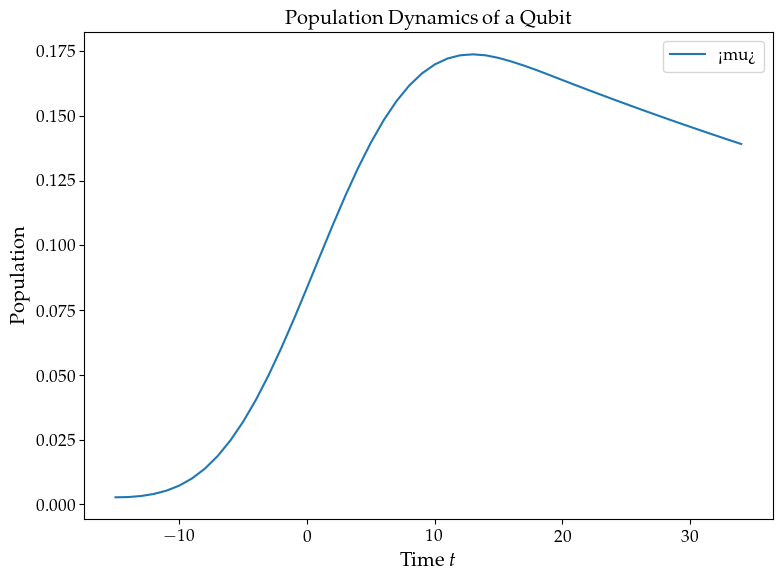

In [6]:
t_coh = sim_oqs.simulation_config.t_coh
t_wait = sim_oqs.simulation_config.t_wait
times = sim_oqs.times_local
fwhms = sim_oqs.laser.pulse_fwhms

full_sequence = sim_oqs.laser
n_pulses = len(full_sequence.pulses)

if n_pulses < 2:
    raise ValueError("Need at least 2 pulses for segmented evolution")

# Initialize variables for loop
current_state = sim_oqs.system.psi_ini
prev_pulse_start_idx = 0

from qspectro2d.spectroscopy.calculations import _ensure_valid_times, _compute_next_start_point, compute_pulse_evolution

# Loop over first n_pulses - 1 segments
for pulse_idx in range(n_pulses - 1):
    # Calculate pulse start index
    if pulse_idx == 0:
        # First pulse: start at t_coh - fwhm
        pulse_start_idx = np.abs(times - (t_coh - fwhms[pulse_idx + 1])).argmin()
        times_segment = _ensure_valid_times(times[: pulse_start_idx + 1], times)
    elif pulse_idx == 1:
        pulse_start_idx = np.abs(times - (t_coh + t_wait - fwhms[pulse_idx + 1])).argmin()
    else:
        raise ValueError("STILL TODO implement general n-pulse evolution")
        
    times_segment = times[prev_pulse_start_idx : pulse_start_idx + 1]
    times_segment = _ensure_valid_times(times_segment, times, prev_pulse_start_idx)
    
    # Update simulation parameters for this segment
    sim_oqs.times_local = times_segment
    sim_oqs.laser = LaserPulseSequence(pulses=full_sequence.pulses[:pulse_idx + 1])
    sim_oqs.system.psi_ini = current_state
    
    # Compute evolution for this segment
    current_state = _compute_next_start_point(sim_oqs=sim_oqs)
    
    # Update for next iteration
    print("pulse start idx:", pulse_start_idx, "prev pulse start idx:", prev_pulse_start_idx)
    prev_pulse_start_idx = pulse_start_idx

# Final segment: evolution with detection (last pulse)
times_final = _ensure_valid_times(times[pulse_start_idx:], times, pulse_start_idx)
sim_oqs.times_local = times_final
print(times_final, sim_oqs.times_det, sim_oqs.times_det_actual)
sim_oqs.laser = full_sequence
sim_oqs.system.psi_ini = current_state

data_final = compute_pulse_evolution(sim_oqs=sim_oqs, store_states=True)
sim_oqs.times_local = times

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(data_final.times, np.abs(complex_polarization(sim_oqs.system.Dip_op, data_final.states)), label=f'<mu>')
plt.xlabel(r"Time $t$")
plt.ylabel(r"Population")
plt.title(r"Population Dynamics of a Qubit")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
import numpy as np

# =============================
# DEMO: Subtracting two lists of numbers elementwise
# =============================

list_a = [10, 20, 30, 40, 50]
list_b = [1, 2, 3, 4, 5]

# Subtracting lists directly raises an error
try:
    result = list_a - list_b
except TypeError as e:
    print("Direct subtraction error:", e)

# Elementwise subtraction using numpy
arr_a      = np.array(list_a)
arr_b      = np.array(list_b)
result_np  = arr_a - arr_b
print("Elementwise subtraction (numpy):", result_np)

# Elementwise subtraction using list comprehension
result_lc = [a - b for a, b in zip(list_a, list_b)]
print("Elementwise subtraction (list comprehension):", result_lc)

Direct subtraction error: unsupported operand type(s) for -: 'list' and 'list'
Elementwise subtraction (numpy): [ 9 18 27 36 45]
Elementwise subtraction (list comprehension): [9, 18, 27, 36, 45]


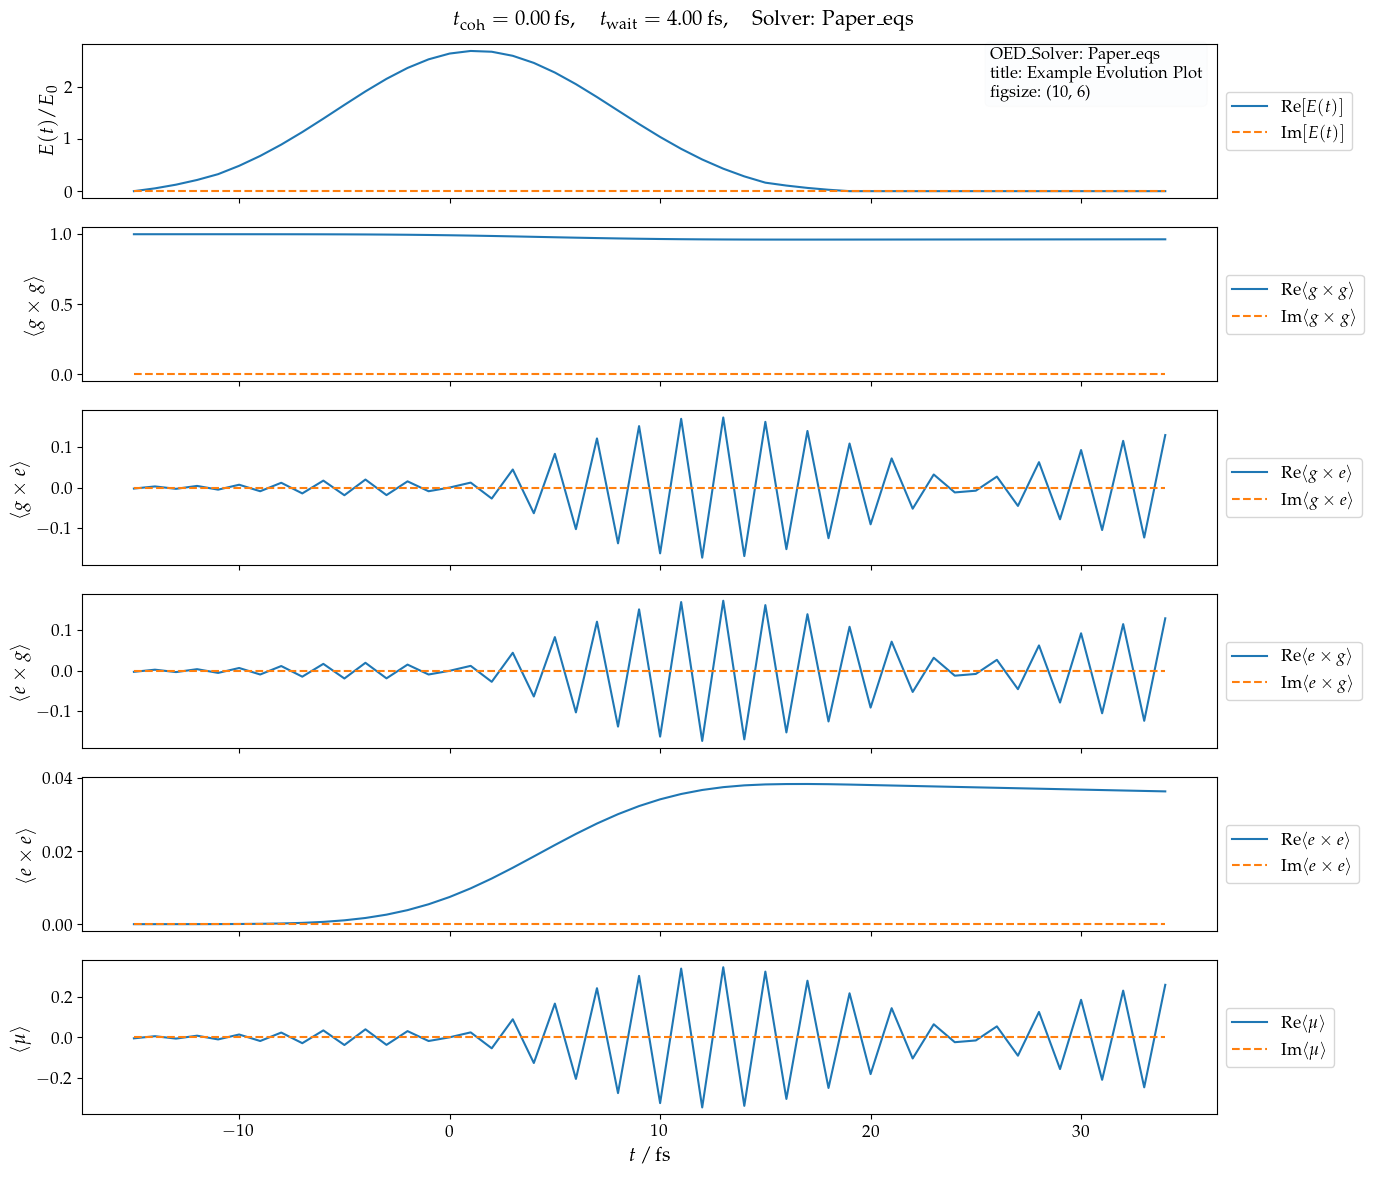

In [8]:
times, datas, sim_oqs = compute_1d_polarization(sim_oqs=sim_oqs, plot_example_evo=True)
RWA_SL = sim_oqs.simulation_config.RWA_SL

plot_example_evo(times, datas, sim_oqs.laser, t_coh, t_wait, RWA_SL=RWA_SL, OED_Solver = sim_oqs.simulation_config.ODE_Solver, observable_strs=sim_oqs.observable_strs, title="Example Evolution Plot", figsize=(10, 6))

In [9]:
detection_time = t_coh + t_wait
detection_start_idx = np.abs(data_final.times - detection_time).argmin()
detection_start_idx, detection_time - sim_oqs.times_local[detection_start_idx]

actual_det_times = data_final.times[detection_start_idx:]
actual_det_times

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34.])

The data will be padded with zeros to match the detection times.


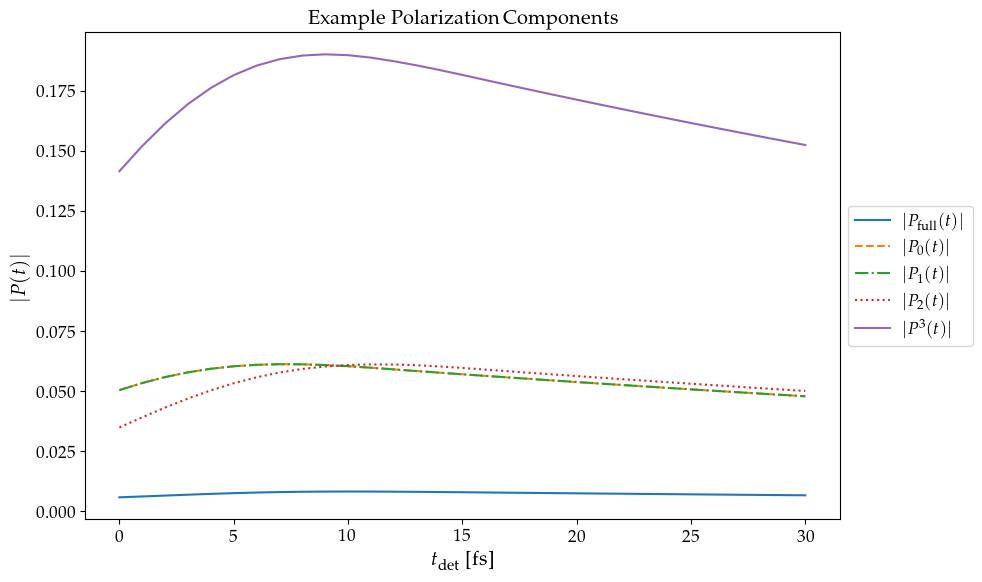

In [10]:
plot_data = compute_1d_polarization(sim_oqs, time_cut=time_cut, plot_example_polarization = True)
P_full, P_only0, P_only1, P_only2 = plot_data
times = sim_oqs.times_det

pulse_seq = sim_oqs.laser
RWA_SL = sim_oqs.simulation_config.RWA_SL
observable_strs = sim_oqs.observable_strs

plot_example_polarization(times, P_full, P_only0, P_only1, P_only2)

In [11]:
# =============================
# TEST: extract_ift_signal_component function
# =============================

### Test the IFT signal component extraction function
print("Testing extract_ift_signal_component function...")

# Create test phase array and results matrix
phases = [0, np.pi/2, np.pi, 3*np.pi/2]  # Standard phase cycling
n_phases = len(phases)

# Create test data - simulate phase-cycled results
test_times = np.linspace(0, 50, 100)
dt_test = test_times[1] - test_times[0]

print(f"Test times shape: {test_times.shape}")
print(f"Time step dt: {dt_test:.3f}")
print(f"Number of phases: {n_phases}")

# Generate synthetic phase-cycled data
results_matrix = np.zeros((n_phases, n_phases), dtype=object)

for phi1_idx, phi_1 in enumerate(phases):
    for phi2_idx, phi_2 in enumerate(phases):
        # Create complex signal with phase-dependent amplitude
        base_signal = np.exp(1j * 0.1 * test_times)  # Base oscillation
        phase_modulation = np.exp(1j * (phi_1 + phi_2))  # Phase modulation
        
        # Add some realistic features
        envelope = np.exp(-0.02 * test_times)  # Decay envelope
        noise = 0.05 * (np.random.randn(len(test_times)) + 1j * np.random.randn(len(test_times)))
        
        results_matrix[phi1_idx, phi2_idx] = (base_signal * phase_modulation * envelope + noise)

print(f"Results matrix shape: {results_matrix.shape}")
print(f"Each element shape: {results_matrix[0, 0].shape}")

try:
    # Test different signal components
    test_components = [
        [-1, 1, 0],   # Common component in 2D spectroscopy
        [1, -1, 0],   # Another common component
        [0, 0, 0],    # Zero component (should give average)
        [1, 1, 0],    # Positive component
        [-1, -1, 0],  # Negative component
    ]
    
    for component in test_components:
        print(f"\n--- Testing component {component} ---")
        
        # Extract IFT signal component
        extracted_signal = extract_ift_signal_component(
            results_matrix=results_matrix,
            phases=phases,
            component=component
        )
        
        print(f"Extracted signal shape: {extracted_signal.shape}")
        print(f"Signal type: {type(extracted_signal)}")
        print(f"Signal dtype: {extracted_signal.dtype}")
        print(f"Max amplitude: {np.max(np.abs(extracted_signal)):.4f}")
        print(f"Mean amplitude: {np.mean(np.abs(extracted_signal)):.4f}")
        
        # Check if signal is complex
        if np.iscomplexobj(extracted_signal):
            print(f"Real part range: [{np.min(np.real(extracted_signal)):.4f}, {np.max(np.real(extracted_signal)):.4f}]")
            print(f"Imag part range: [{np.min(np.imag(extracted_signal)):.4f}, {np.max(np.imag(extracted_signal)):.4f}]")
        
        # Verify the extracted signal has the same length as input
        if len(extracted_signal) == len(test_times):
            print("✓ Output length matches input length")
        else:
            print(f"❌ Length mismatch: expected={len(test_times)}, got={len(extracted_signal)}")
    
    print(f"\n{'='*50}")
    print("✅ extract_ift_signal_component function tests completed successfully!")
    
except Exception as e:
    print(f"❌ ERROR testing extract_ift_signal_component: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()

Testing extract_ift_signal_component function...
Test times shape: (100,)
Time step dt: 0.505
Number of phases: 4
Results matrix shape: (4, 4)
Each element shape: (100,)

--- Testing component [-1, 1, 0] ---
0,0 phase_factor=(1-0j)
0,1 phase_factor=(6.123233995736766e-17-1j)
0,2 phase_factor=(-1-1.2246467991473532e-16j)
0,3 phase_factor=(-1.8369701987210297e-16+1j)
1,0 phase_factor=(6.123233995736766e-17+1j)
1,1 phase_factor=(1-0j)
1,2 phase_factor=(6.123233995736766e-17-1j)
1,3 phase_factor=(-1-1.2246467991473532e-16j)
2,0 phase_factor=(-1+1.2246467991473532e-16j)
2,1 phase_factor=(6.123233995736766e-17+1j)
2,2 phase_factor=(1-0j)
2,3 phase_factor=(6.123233995736766e-17-1j)
3,0 phase_factor=(-1.8369701987210297e-16-1j)
3,1 phase_factor=(-1+1.2246467991473532e-16j)
3,2 phase_factor=(6.123233995736766e-17+1j)
3,3 phase_factor=(1-0j)
Extracted signal shape: (100,)
Signal type: <class 'numpy.ndarray'>
Signal dtype: complex64
Max amplitude: 0.0356
Mean amplitude: 0.0137
Real part range: [-

In [12]:

# Additional test: Test with identical data (should give zero for non-zero components)
print(f"\n--- Testing with identical data (debugging phase cycling issue) ---")
try:
    # Create test matrix where all elements are identical (simulating your issue)
    identical_signal = np.array([1+1j, 2+2j, 3+3j, 4+4j])
    identical_matrix = np.zeros((n_phases, n_phases), dtype=object)
    
    for i in range(n_phases):
        for j in range(n_phases):
            identical_matrix[i, j] = identical_signal.copy()
    
    print("Testing identical data with component [-1, 1, 0]:")
    result_identical = extract_ift_signal_component(
        results_matrix=identical_matrix,
        phases=phases,
        component=[-1, 1, 0]
    )
    
    print(f"Result with identical data: {result_identical}")
    print("This should be close to zero because all phase combinations are identical!")
    
    # Test with component [0, 0, 0] - should give the average
    print("\nTesting identical data with component [0, 0, 0]:")
    result_average = extract_ift_signal_component(
        results_matrix=identical_matrix,
        phases=phases,
        component=[0, 0, 0]
    )
    print(f"Result with [0,0,0] component: {result_average}")
    print("This should equal the original signal (average of identical elements)")
    
except Exception as e:
    print(f"Identical data test failed: {e}")
    import traceback
    traceback.print_exc()
    

print("\n🔍 IFT signal component extraction testing complete!")


--- Testing with identical data (debugging phase cycling issue) ---
Testing identical data with component [-1, 1, 0]:
0,0 phase_factor=(1-0j)
0,1 phase_factor=(6.123233995736766e-17-1j)
0,2 phase_factor=(-1-1.2246467991473532e-16j)
0,3 phase_factor=(-1.8369701987210297e-16+1j)
1,0 phase_factor=(6.123233995736766e-17+1j)
1,1 phase_factor=(1-0j)
1,2 phase_factor=(6.123233995736766e-17-1j)
1,3 phase_factor=(-1-1.2246467991473532e-16j)
2,0 phase_factor=(-1+1.2246467991473532e-16j)
2,1 phase_factor=(6.123233995736766e-17+1j)
2,2 phase_factor=(1-0j)
2,3 phase_factor=(6.123233995736766e-17-1j)
3,0 phase_factor=(-1.8369701987210297e-16-1j)
3,1 phase_factor=(-1+1.2246467991473532e-16j)
3,2 phase_factor=(6.123233995736766e-17+1j)
3,3 phase_factor=(1-0j)
Result with identical data: [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
This should be close to zero because all phase combinations are identical!

Testing identical data with component [0, 0, 0]:
0,0 phase_factor=(1-0j)
0,1 phase_factor=(1-0j)
0,2 phase_fact

In [13]:
local_sim_oqs = deepcopy(sim_oqs)
test_time = local_sim_oqs.simulation_config.t_coh  # Time when second pulse is active
bphases1 = sim_oqs.laser.pulse_phases
bphases2 = [p.pulse_phase for p in sim_oqs.laser.pulses]
H_a = sim_oqs.H_int_sl(test_time)  # Hamiltonian at t=0
print("BEFORE Laser pulse phases:", bphases1, bphases2)
local_sim_oqs = deepcopy(sim_oqs)

# DEBUG: Check phases before and after update
phi1, phi2, DETECTION_PHASE = 3, 3, 0
local_sim_oqs.laser.update_phases(
    phases=[phi1, phi2, DETECTION_PHASE]
)  # Update the laser phases in the local copy

bphases1 = local_sim_oqs.laser.pulse_phases
bphases2 = [p.pulse_phase for p in local_sim_oqs.laser.pulses]
H_b = local_sim_oqs.H_int_sl(test_time)  # Hamiltonian at t=0
print("AFTER update Laser pulse phases:", bphases1, bphases2)

print("Hamiltonian before vs afterupdate:", H_a, H_b)

BEFORE Laser pulse phases: [0.0, 0.0, 0.0] [0.0, 0.0, 0.0]
AFTER update Laser pulse phases: [3, 3, 0] [3, 3, 0]
Hamiltonian before vs afterupdate: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.         -0.01316779]
 [-0.01316779  0.        ]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.        +0.j       0.00548839-0.001323j]
 [0.00548839+0.001323j 0.        +0.j      ]]


## TEST THE Phase Cycling and data generation

In [14]:
from qspectro2d.spectroscopy.calculations import compute_1d_polarization
local_sim_oqs.laser.update_phases(
    phases=[1,0,0])
data1 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data1)

local_sim_oqs.laser.update_phases(
    phases=[0,1,0])
data2 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data2)

local_sim_oqs.laser.update_phases(
    phases=[2,0,0])
data3 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data3)

print("The difference between data1 and data2 and data3 is:", 
      data2 - data1, data3 - data1, data3 - data2
)

[1, 0, 0]
[ 0.00231465+0.00475332j -0.00296914-0.00463717j  0.00364109+0.00443978j
 -0.00431255-0.00414036j  0.00495802+0.00372611j -0.00554728-0.00319295j
  0.00605007+0.00254753j -0.00644011-0.00180649j  0.00669819+0.00099412j
 -0.00681308-0.00013859j  0.0067824 -0.00073059j -0.00661394+0.00158522j
  0.00631957-0.00240202j -0.00590844+0.00316201j  0.00540346-0.00385104j
 -0.00481832+0.00446188j  0.00416462-0.00498444j -0.00345243+0.00540462j
  0.00270431-0.00573292j -0.00192972+0.0059607j   0.0011417 -0.00608654j
 -0.0003533 +0.00611058j -0.00042265-0.00603495j  0.00117385+0.00586323j
 -0.00188869-0.00560032j  0.00255639+0.00525263j -0.00316723-0.00482773j
  0.00371259+0.00433431j -0.00418514-0.00378194j  0.0045789 +0.00318095j
 -0.00488929-0.00254222j]
[0, 1, 0]
[ 0.00231466+0.00475332j -0.00296914-0.00463717j  0.00364109+0.00443978j
 -0.00431255-0.00414036j  0.00495802+0.00372612j -0.00554728-0.00319294j
  0.00605007+0.00254754j -0.00644011-0.0018065j   0.00669819+0.00099412j
 -0.0